In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.cluster import KMeans


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

zip_path = "/content/drive/MyDrive/Position_task_with_dots_synchronised_min.npz.zip"
print(os.path.exists(zip_path))

True


In [ ]:
!unzip -q "/content/drive/MyDrive/Position_task_with_dots_synchronised_min.npz.zip" -d /content/eegeyenet_prepared

In [ ]:
!ps aux | grep unzip

root        5040  0.0  0.0   7372  3584 ?        S    02:02   0:00 /bin/bash -c ps aux | grep unzip
root        5042  0.0  0.0   6480  2320 ?        S    02:02   0:00 grep unzip


In [ ]:

!ls /content/eegeyenet_prepared


__MACOSX  Position_task_with_dots_synchronised_min.npz


In [ ]:
import numpy as np
import torch

path = "/content/eegeyenet_prepared/Position_task_with_dots_synchronised_min.npz"

data = np.load(path)

print(data.files)

['EEG', 'labels']


In [ ]:
EEG = data["EEG"]

In [ ]:
labels = data["labels"]

In [ ]:
# Use first 128 EEG channels (paper setup)
EEG = EEG[:, :, :128]      # (N, 500, 128)

# Raw gaze coordinates (screen space, pixels)
xy = labels[:, 1:3].astype(np.float32)


In [ ]:
print("EEG shape:", EEG.shape)
print("xy shape:", xy.shape)


EEG shape: (21464, 500, 128)
xy shape: (21464, 2)


In [ ]:
import numpy as np

In [ ]:


label_vals = labels[:, 0]   # change index if your class label is elsewhere

unique_vals, counts = np.unique(label_vals, return_counts=True)

for v, c in zip(unique_vals, counts):
    print(f"Label {v}: {c} samples")

Label 1.0: 131 samples
Label 2.0: 127 samples
Label 3.0: 139 samples
Label 4.0: 133 samples
Label 5.0: 136 samples
Label 6.0: 132 samples
Label 7.0: 133 samples
Label 8.0: 131 samples
Label 9.0: 132 samples
Label 10.0: 132 samples
Label 11.0: 134 samples
Label 12.0: 128 samples
Label 13.0: 129 samples
Label 14.0: 128 samples
Label 15.0: 132 samples
Label 16.0: 112 samples
Label 17.0: 131 samples
Label 18.0: 131 samples
Label 19.0: 130 samples
Label 20.0: 123 samples
Label 21.0: 107 samples
Label 22.0: 126 samples
Label 23.0: 103 samples
Label 24.0: 108 samples
Label 25.0: 121 samples
Label 26.0: 106 samples
Label 27.0: 93 samples
Label 28.0: 118 samples
Label 29.0: 103 samples
Label 30.0: 106 samples
Label 31.0: 113 samples
Label 32.0: 114 samples
Label 33.0: 106 samples
Label 34.0: 109 samples
Label 35.0: 113 samples
Label 36.0: 115 samples
Label 37.0: 131 samples
Label 38.0: 121 samples
Label 39.0: 128 samples
Label 40.0: 132 samples
Label 41.0: 123 samples
Label 42.0: 123 samples
La

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [ ]:
# Number of dot locations (you saw ~25 clearly)
K = 25

kmeans = KMeans(n_clusters=K, random_state=0, n_init=20)
cluster_id = kmeans.fit_predict(xy)          # (N,)
cluster_centers = kmeans.cluster_centers_    # (K, 2)

print("Recovered clusters:", K)
print("Cluster centers shape:", cluster_centers.shape)

Recovered clusters: 25
Cluster centers shape: (25, 2)


In [ ]:
# Raw gaze coordinates (screen space, pixels)
xy = labels[:, 1:3].astype(np.float32)

print("EEG shape:", EEG.shape)
print("xy range:")
print("  x:", xy[:,0].min(), xy[:,0].max())
print("  y:", xy[:,1].min(), xy[:,1].max())


EEG shape: (21464, 500, 128)
xy range:
  x: -724.6 840.4
  y: -122.5 895.7


In [ ]:
# ------------------------------------------------------------
# 2. Normalize gaze coordinates (for clustering + distances)
# ------------------------------------------------------------
xy_mean = xy.mean(axis=0)
xy_std  = xy.std(axis=0)
xy_std[xy_std < 1e-6] = 1.0   # numerical safety

xy_n = (xy - xy_mean) / xy_std    # normalized gaze space


In [ ]:
# ------------------------------------------------------------
# 3. Recover spatial dot locations via k-means
# ------------------------------------------------------------
K = 25   # number of fixation targets (from your plot)


In [ ]:
kmeans = KMeans(
    n_clusters=K,
    n_init=20,
    random_state=42
)

In [ ]:

cluster_id = kmeans.fit_predict(xy_n)        # (N,)
cluster_centers_n = kmeans.cluster_centers_  # (K, 2) normalized

In [ ]:
# Convert centers back to pixel space (for interpretation)
cluster_centers_px = cluster_centers_n * xy_std + xy_mean

print("Recovered clusters:", K)
print("cluster_centers_n shape:", cluster_centers_n.shape)
print("cluster_centers_px shape:", cluster_centers_px.shape)

Recovered clusters: 25
cluster_centers_n shape: (25, 2)
cluster_centers_px shape: (25, 2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


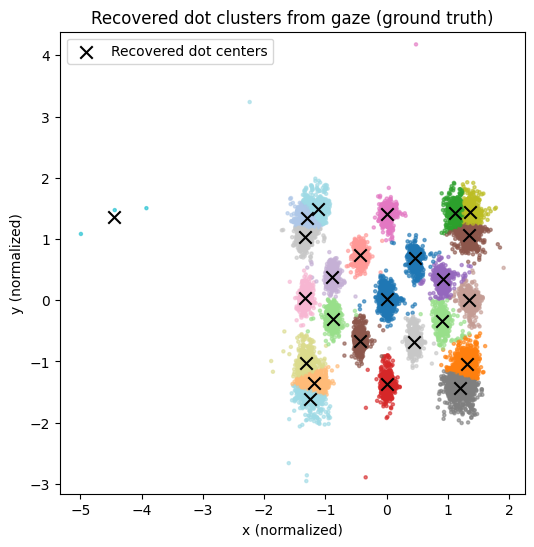

In [ ]:
# ------------------------------------------------------------
# 4. Verification plot (normalized space)
# ------------------------------------------------------------
plt.figure(figsize=(6, 6))

plt.scatter(
    xy_n[:, 0],
    xy_n[:, 1],
    c=cluster_id,
    cmap="tab20",
    s=5,
    alpha=0.6
)

plt.scatter(
    cluster_centers_n[:, 0],
    cluster_centers_n[:, 1],
    c="black",
    s=80,
    marker="x",
    label="Recovered dot centers"
)

plt.title("Recovered dot clusters from gaze (ground truth)")
plt.xlabel("x (normalized)")
plt.ylabel("y (normalized)")
plt.axis("equal")
plt.legend()
plt.show()


In [ ]:
dist_to_center = np.linalg.norm(
    xy_n - cluster_centers_n[cluster_id],
    axis=1
)   # (N,)

In [ ]:
keep_mask = np.zeros(len(xy_n), dtype=bool)

for k in range(K):
    idx = np.where(cluster_id == k)[0]
    d = dist_to_center[idx]

    median = np.median(d)
    mad = np.median(np.abs(d - median)) + 1e-6

    threshold = median + 3.0 * mad   # robust ~3σ rule
    keep_mask[idx] = d <= threshold

In [ ]:
xy_n_clean = xy_n[keep_mask]
cluster_id_clean = cluster_id[keep_mask]
EEG_clean = EEG[keep_mask]

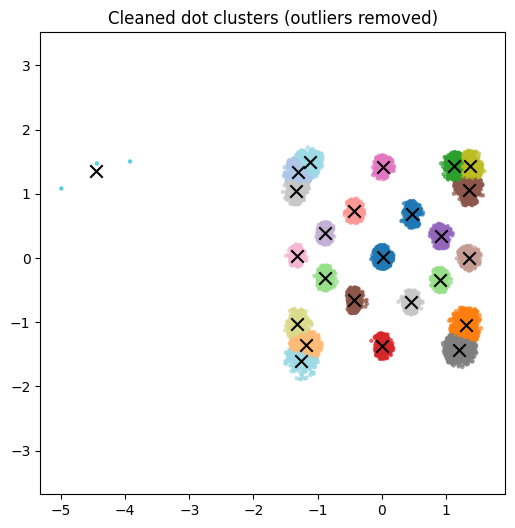

Kept 91.66% of samples


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(
    xy_n_clean[:,0],
    xy_n_clean[:,1],
    c=cluster_id_clean,
    cmap="tab20",
    s=5,
    alpha=0.6
)
plt.scatter(
    cluster_centers_n[:,0],
    cluster_centers_n[:,1],
    c="black",
    s=80,
    marker="x"
)
plt.title("Cleaned dot clusters (outliers removed)")
plt.axis("equal")
plt.show()

print(f"Kept {keep_mask.mean()*100:.2f}% of samples")

In [ ]:
# cluster_centers_n: (K, 2)
# cluster_id_clean: (N_clean,)

# Find the cluster whose center is far left
outlier_cluster = np.argmin(cluster_centers_n[:, 0])

print("Outlier cluster ID:", outlier_cluster)
print("Outlier cluster center (normalized):", cluster_centers_n[outlier_cluster])

Outlier cluster ID: 22
Outlier cluster center (normalized): [-4.45063    1.3524835]


In [ ]:
keep_mask_2 = cluster_id_clean != outlier_cluster

xy_n_final = xy_n_clean[keep_mask_2]
cluster_id_final = cluster_id_clean[keep_mask_2]
EEG_final = EEG_clean[keep_mask_2]


In [ ]:
# Remap cluster IDs to [0, K-2]
unique_ids = np.unique(cluster_id_final)
id_map = {old: new for new, old in enumerate(unique_ids)}

cluster_id_final = np.array([id_map[c] for c in cluster_id_final])

# Update centers
cluster_centers_n_final = cluster_centers_n[unique_ids]
cluster_centers_px_final = cluster_centers_px[unique_ids]

print("Final number of clusters:", len(unique_ids))


Final number of clusters: 24


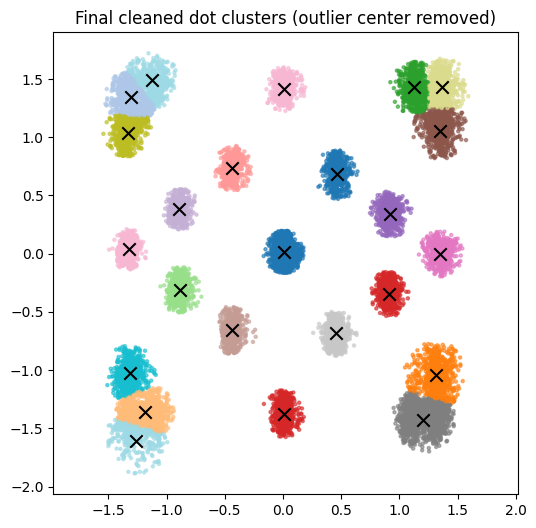

Final kept samples: 19670


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(
    xy_n_final[:,0],
    xy_n_final[:,1],
    c=cluster_id_final,
    cmap="tab20",
    s=5,
    alpha=0.6
)
plt.scatter(
    cluster_centers_n_final[:,0],
    cluster_centers_n_final[:,1],
    c="black",
    s=80,
    marker="x"
)
plt.title("Final cleaned dot clusters (outlier center removed)")
plt.axis("equal")
plt.show()

print(f"Final kept samples: {len(xy_n_final)}")

In [ ]:
import string

K = cluster_centers_n_final.shape[0]

# A, B, C, ..., X
cluster_names = list(string.ascii_uppercase[:K])

# Sanity check
print(cluster_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']


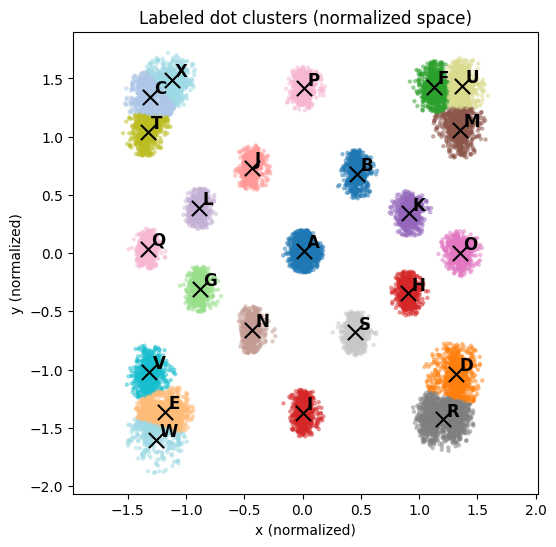

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Plot all EEG samples (colored by cluster id)
plt.scatter(
    xy_n_final[:, 0],
    xy_n_final[:, 1],
    c=cluster_id_final,
    cmap="tab20",
    s=5,
    alpha=0.4
)

# Plot cluster centers
plt.scatter(
    cluster_centers_n_final[:, 0],
    cluster_centers_n_final[:, 1],
    c="black",
    s=120,
    marker="x"
)

# Annotate each center with A, B, C, ...
for i, name in enumerate(cluster_names):
    x, y = cluster_centers_n_final[i]
    plt.text(
        x + 0.03, y + 0.03,
        name,
        fontsize=12,
        weight="bold",
        color="black"
    )

plt.title("Labeled dot clusters (normalized space)")
plt.xlabel("x (normalized)")
plt.ylabel("y (normalized)")
plt.axis("equal")
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Pairwise Euclidean distances in normalized space
dist_matrix = cdist(
    cluster_centers_n_final,
    cluster_centers_n_final,
    metric="euclidean"
)  # (K, K)

In [ ]:
import pandas as pd

dist_df = pd.DataFrame(
    dist_matrix,
    index=cluster_names,
    columns=cluster_names
)

dist_df

,A,B,C,D,E,F,G,H,I,J,...,O,P,Q,R,S,T,U,V,W,X
A,0.000000,0.807545,1.868999,1.678446,1.821125,1.800397,0.948751,0.969300,1.388967,0.845008,...,1.342627,1.397973,1.335317,1.873241,0.825392,1.686835,1.962973,1.681827,2.058587,1.858144
B,0.807545,0.000000,1.891500,1.918754,2.625052,0.996228,1.673202,1.118977,2.105462,0.904801,...,1.116994,0.861715,1.903791,2.234537,1.362261,1.832323,1.173454,2.463997,2.865003,1.782588
C,1.868999,1.891500,0.000000,3.542025,2.705974,2.433353,1.706726,2.785473,3.017775,1.061713,...,2.977496,1.319036,1.305358,3.738498,2.681361,0.304704,2.674712,2.364825,2.950176,0.232985
D,1.678446,1.918754,3.542025,0.000000,2.519874,2.474188,2.314827,0.803356,1.349359,2.492127,...,1.040978,2.777640,2.852127,0.404386,0.933846,3.364976,2.472686,2.629893,2.635223,3.512122
E,1.821125,2.625052,2.705974,2.519874,0.000000,3.620573,1.092720,2.325519,1.192170,2.221991,...,2.878342,3.020073,1.405171,2.388720,1.772386,2.404044,3.782956,0.362704,0.257436,2.848866
F,1.800397,0.996228,2.433353,2.474188,3.620573,0.000000,2.655341,1.787248,3.016198,1.710834,...,1.444405,1.114808,2.818182,2.856676,2.213336,2.487398,0.241379,3.457744,3.858969,2.250319
G,0.948751,1.673202,1.706726,2.314827,1.092720,2.655341,0.000000,1.790884,1.386640,1.133450,...,2.255322,1.941002,0.564051,2.366094,1.385198,1.422298,2.845380,0.832930,1.350143,1.814353
H,0.969300,1.118977,2.785473,0.803356,2.325519,1.787248,1.790884,0.000000,1.366333,1.725066,...,0.563150,1.975272,2.267231,1.121093,0.565424,2.633722,1.837335,2.323688,2.506827,2.737744
I,1.388967,2.105462,3.017775,1.349359,1.192170,3.016198,1.386640,1.366333,0.000000,2.152779,...,1.922579,2.786940,1.941917,1.196896,0.823395,2.759631,3.118403,1.368593,1.287406,3.077308
J,0.845008,0.904801,1.061713,2.492127,2.221991,1.710834,1.133450,1.725066,2.152779,0.000000,...,1.933037,0.815201,1.127761,2.713008,1.670379,0.944860,1.935702,1.961438,2.479127,1.020650


In [ ]:
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np

# Pairwise Euclidean distances in PIXEL space
dist_matrix_px = cdist(
    cluster_centers_px_final,
    cluster_centers_px_final,
    metric="euclidean"
)  # (K, K)

In [ ]:
import string

K = cluster_centers_px_final.shape[0]
cluster_names = list(string.ascii_uppercase[:K])

dist_df_px = pd.DataFrame(
    dist_matrix_px,
    index=cluster_names,
    columns=cluster_names
)

dist_df_px

,A,B,C,D,E,F,G,H,I,J,...,O,P,Q,R,S,T,U,V,W,X
A,0.000000,140.557049,353.337316,332.098248,334.314354,323.601497,207.293488,210.299319,198.307303,144.023758,...,304.342800,199.593141,302.670063,340.210716,141.366894,337.198914,368.375794,334.669788,369.045381,331.933236
B,140.557049,0.000000,412.643834,312.097509,474.214750,183.657633,336.723956,177.763926,311.233181,204.906527,...,223.084828,146.798390,416.418959,344.455773,194.507923,410.549345,230.754120,471.222770,509.389245,378.302014
C,353.337316,412.643834,0.000000,684.650800,386.935749,551.402411,254.865298,556.976856,489.043289,215.337030,...,632.246034,298.749489,186.402373,692.932113,492.408559,43.725855,606.109835,337.636679,421.289884,46.233662
D,332.098248,312.097509,684.650800,0.000000,568.414258,354.817274,508.791191,135.196878,300.156953,470.981051,...,148.764307,458.247373,618.096441,60.986934,202.064418,669.256515,353.151595,596.148571,588.947414,660.180713
E,334.314354,474.214750,386.935749,568.414258,0.000000,657.750087,164.842978,496.011496,270.236273,343.409376,...,606.855535,479.805100,202.163929,541.355016,383.552668,344.205950,702.503244,56.652319,38.998100,406.880831
F,323.601497,183.657633,551.402411,354.817274,657.750087,0.000000,518.348039,258.019340,473.483973,367.997886,...,210.028854,252.697134,590.106504,408.086194,337.490917,559.693503,54.709154,654.491115,692.644175,510.002553
G,207.293488,336.723956,254.865298,508.791191,164.842978,518.348039,0.000000,405.916129,252.462388,179.752945,...,508.301420,318.616748,112.228064,498.944370,307.144915,217.926881,567.308673,141.243356,203.836990,262.517441
H,210.299319,177.763926,556.976856,135.196878,496.011496,258.019340,405.916129,0.000000,251.412752,341.809951,...,112.048136,323.278357,509.477314,168.273642,113.836950,544.898527,274.461537,513.141686,523.128985,529.941155
I,198.307303,311.233181,489.043289,300.156953,270.236273,473.483973,252.462388,251.412752,0.000000,317.202907,...,362.414719,397.900437,363.337043,271.149867,141.268894,459.151019,505.470323,303.989238,288.935100,482.424226
J,144.023758,204.906527,215.337030,470.981051,343.409376,367.997886,179.752945,341.809951,317.202907,0.000000,...,418.837166,140.651837,224.481753,483.238369,285.386122,207.261017,421.109386,319.813767,382.320252,189.303692


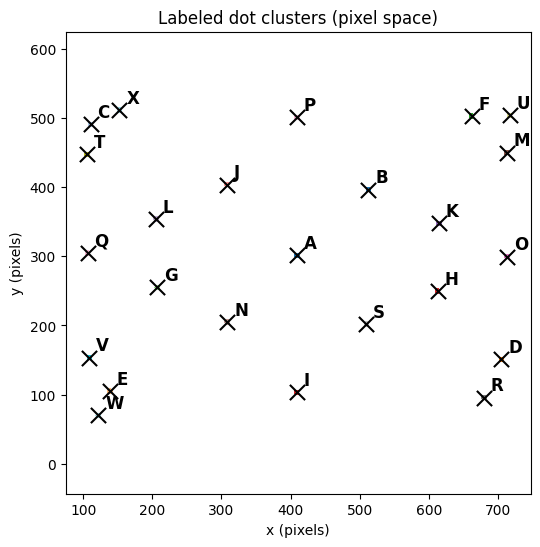

In [ ]:
plt.figure(figsize=(6,6))

# Plot all EEG samples in pixel space
plt.scatter(
    cluster_centers_px_final[cluster_id_final, 0],
    cluster_centers_px_final[cluster_id_final, 1],
    c=cluster_id_final,
    cmap="tab20",
    s=5,
    alpha=0.4
)

# Plot pixel-space cluster centers
plt.scatter(
    cluster_centers_px_final[:, 0],
    cluster_centers_px_final[:, 1],
    c="black",
    s=120,
    marker="x"
)

# Annotate with A, B, C, ...
for i, name in enumerate(cluster_names):
    x, y = cluster_centers_px_final[i]
    plt.text(
        x + 10, y + 10,
        name,
        fontsize=12,
        weight="bold",
        color="black"
    )

plt.title("Labeled dot clusters (pixel space)")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.axis("equal")
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Pairwise distances in normalized space
D_n = cdist(
    cluster_centers_n_final,
    cluster_centers_n_final,
    metric="euclidean"
)

# Ignore self-distance
np.fill_diagonal(D_n, np.inf)

# Nearest neighbor distance for each cluster
nn_dist = D_n.min(axis=1)   # (K,)

In [ ]:
print("Nearest-neighbor distances (normalized):")
print("  mean :", nn_dist.mean())
print("  median:", np.median(nn_dist))
print("  min  :", nn_dist.min())
print("  max  :", nn_dist.max())

Nearest-neighbor distances (normalized):
  mean : 0.4739730619500624
  median: 0.5515809768036644
  min  : 0.23298504817940777
  max  : 0.8233950856652831


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import string

K = cluster_centers_n_final.shape[0]
names = list(string.ascii_uppercase[:K])

Dn = cdist(cluster_centers_n_final, cluster_centers_n_final)
Dp = cdist(cluster_centers_px_final, cluster_centers_px_final)

np.fill_diagonal(Dn, np.inf)
np.fill_diagonal(Dp, np.inf)

nn_n = Dn.min(axis=1)
nn_p = Dp.min(axis=1)

order = np.argsort(nn_n)  # closest first

print("Closest dots by NN distance (normalized | pixels):")
for i in order:
    j = np.argmin(Dn[i])
    print(f"{names[i]} ↔ {names[j]} : {nn_n[i]:.3f} | {nn_p[i]:.1f}px")

Closest dots by NN distance (normalized | pixels):
C ↔ X : 0.233 | 43.7px
X ↔ C : 0.233 | 46.2px
U ↔ F : 0.241 | 53.8px
F ↔ U : 0.241 | 54.7px
E ↔ W : 0.257 | 39.0px
W ↔ E : 0.257 | 39.0px
T ↔ C : 0.305 | 43.7px
V ↔ E : 0.363 | 56.7px
M ↔ U : 0.376 | 53.8px
D ↔ R : 0.404 | 61.0px
R ↔ D : 0.404 | 61.0px
K ↔ O : 0.552 | 98.0px
O ↔ K : 0.552 | 109.9px
Q ↔ L : 0.557 | 110.6px
L ↔ Q : 0.557 | 99.2px
H ↔ O : 0.563 | 98.0px
G ↔ Q : 0.564 | 99.2px
S ↔ H : 0.565 | 113.8px
B ↔ K : 0.565 | 113.2px
N ↔ G : 0.567 | 112.9px
J ↔ L : 0.570 | 113.9px
A ↔ B : 0.808 | 139.4px
P ↔ J : 0.815 | 140.7px
I ↔ S : 0.823 | 141.3px


In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGEyeDataset(Dataset):
    def __init__(self, EEG, labels, indices, mean, std):
        self.EEG = EEG
        self.labels = labels
        self.indices = indices
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]

        eeg = self.EEG[idx].astype(np.float32)
        eeg = (eeg - self.mean) / self.std

        label = self.labels[idx]

        return torch.from_numpy(eeg), torch.tensor(label, dtype=torch.long)

In [ ]:
N = len(EEG_final)
indices = np.random.permutation(N)

train_frac, val_frac = 0.7, 0.15
n_train = int(train_frac * N)
n_val = int(val_frac * N)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

In [ ]:
train_eeg = EEG_final[train_idx]
chan_mean = train_eeg.reshape(-1, 128).mean(axis=0)
chan_std  = train_eeg.reshape(-1, 128).std(axis=0)
chan_std[chan_std < 1e-6] = 1.0

In [ ]:
batch_size = 64

train_ds = EEGEyeDataset(EEG_final, cluster_id_final, train_idx, chan_mean, chan_std)
val_ds   = EEGEyeDataset(EEG_final, cluster_id_final, val_idx,   chan_mean, chan_std)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [ ]:
batch_size = 16   # try 32 later if VRAM allows

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,          # GOOD for Colab/A100
    pin_memory=True,        # now beneficial
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-2340218076.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
scaler = torch.amp.GradScaler("cuda")

In [ ]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for eeg, labels in loader:
        eeg = eeg.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                logits, _ = model(eeg)
                loss = criterion(logits, labels)

            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [ ]:
model = EEGViTClassifier(
    num_classes=len(np.unique(cluster_id_final)),
    embed_dim=256
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

NameError: name 'EEGViTClassifier' is not defined

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class EEGPatchEmbedding(nn.Module):
    """
    Input:  (B, 1, 128, 500)
    Output: (B, 768, 16, 14)
    """
    def __init__(self):
        super().__init__()

        # Temporal convolution (time → patches)
        self.temporal = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 36),
            stride=(1, 36),
            padding=(0, 2),
            bias=False
        )

        self.bn = nn.BatchNorm2d(256)
        self.act = nn.GELU()

        # Spatial convolution (channels → spatial patches)
        self.spatial = nn.Conv2d(
            in_channels=256,
            out_channels=768,
            kernel_size=(8, 1),
            stride=(8, 1),
            groups=256,
            bias=False
        )

    def forward(self, x):
        x = self.temporal(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.spatial(x)
        return x

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim=768, heads=12, mlp_dim=3072, drop=0.1):
        super().__init__()

        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=heads,
            dropout=drop,
            batch_first=True
        )

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        h = self.norm1(x)
        x = x + self.attn(h, h, h, need_weights=False)[0]
        h = self.norm2(x)
        x = x + self.mlp(h)
        return x

In [ ]:
class EEGViTClassifier(nn.Module):
    def __init__(
        self,
        num_classes,
        embed_dim=256,
        depth=12,
        drop=0.1
    ):
        super().__init__()

        self.patch_embed = EEGPatchEmbedding()

        # CLS + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 768))
        self.pos_embed = nn.Parameter(torch.zeros(1, 225, 768))
        self.pos_drop = nn.Dropout(drop)

        # Transformer encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(dim=768, heads=12, mlp_dim=3072, drop=drop)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(768)

        # Projection heads
        self.embed_head = nn.Linear(768, embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, eeg):
        """
        eeg: (B, 500, 128)
        """
        B = eeg.size(0)

        # → (B, 1, 128, 500)
        x = eeg.permute(0, 2, 1).unsqueeze(1)

        # Patch embedding
        x = self.patch_embed(x)                 # (B, 768, 16, 14)
        x = x.flatten(2).transpose(1, 2)        # (B, 224, 768)

        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)          # (B, 225, 768)

        # Positional embedding
        x = self.pos_drop(x + self.pos_embed)

        # Transformer
        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        # CLS output
        z = self.embed_head(x[:, 0])             # (B, embed_dim)
        logits = self.classifier(z)              # (B, num_classes)

        return logits, z


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEGViTClassifier(
    num_classes=len(np.unique(cluster_id_final)),
    embed_dim=256
).to(device)

dummy = torch.randn(2, 500, 128).to(device)
logits, z = model(dummy)

print("logits:", logits.shape)  # (2, num_classes)
print("z:", z.shape)            # (2, 256)

logits: torch.Size([2, 24])
z: torch.Size([2, 256])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

In [ ]:
def run_epoch(model, loader, optimizer=None):
    """
    Runs one epoch.
    If optimizer is provided → training mode
    If optimizer is None → evaluation mode
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for eeg, labels in loader:
        eeg = eeg.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits, _ = model(eeg)
            loss = criterion(logits, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    return avg_loss, acc

In [ ]:
epochs = 20

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer
    )

    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

Epoch 01 | Train: loss=2.8551, acc=0.129 | Val: loss=2.5001, acc=0.199
Epoch 02 | Train: loss=2.3613, acc=0.235 | Val: loss=2.3298, acc=0.242
Epoch 03 | Train: loss=2.2352, acc=0.261 | Val: loss=2.2013, acc=0.269
Epoch 04 | Train: loss=2.1682, acc=0.273 | Val: loss=2.1589, acc=0.271
Epoch 05 | Train: loss=2.1263, acc=0.290 | Val: loss=2.0886, acc=0.311
Epoch 06 | Train: loss=2.1115, acc=0.295 | Val: loss=2.1644, acc=0.272
Epoch 07 | Train: loss=2.0894, acc=0.297 | Val: loss=2.1212, acc=0.295
Epoch 08 | Train: loss=2.0513, acc=0.314 | Val: loss=2.0208, acc=0.319
Epoch 09 | Train: loss=2.0406, acc=0.320 | Val: loss=2.0163, acc=0.331
Epoch 10 | Train: loss=2.0190, acc=0.321 | Val: loss=1.9833, acc=0.340
Epoch 11 | Train: loss=2.0762, acc=0.304 | Val: loss=2.1016, acc=0.300
Epoch 12 | Train: loss=2.0416, acc=0.320 | Val: loss=2.0807, acc=0.315
Epoch 13 | Train: loss=2.0411, acc=0.319 | Val: loss=1.9821, acc=0.337
Epoch 14 | Train: loss=2.0345, acc=0.322 | Val: loss=2.0107, acc=0.316
Epoch 

In [ ]:
epochs = 20

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer
    )

    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

Epoch 01 | Train: loss=2.8344, acc=0.138 | Val: loss=2.5949, acc=0.177
Epoch 02 | Train: loss=2.3654, acc=0.227 | Val: loss=2.1829, acc=0.276
Epoch 03 | Train: loss=2.1905, acc=0.269 | Val: loss=2.0974, acc=0.309
Epoch 04 | Train: loss=2.1273, acc=0.284 | Val: loss=2.0055, acc=0.333
Epoch 05 | Train: loss=2.0547, acc=0.310 | Val: loss=1.9719, acc=0.345


KeyboardInterrupt: 

In [ ]:
epochs = 20

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer
    )

    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

In [ ]:
import torch
import numpy as np

model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for eeg, labels in val_loader:
        eeg = eeg.to(device)
        logits, _ = model(eeg)

        preds = logits.argmax(dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_pred.append(preds)
        all_true.append(labels)

all_pred = np.concatenate(all_pred)
all_true = np.concatenate(all_true)

print("Collected predictions:", all_pred.shape)

Collected predictions: (2950,)


In [ ]:
true_xy = cluster_centers_px_final[all_true]   # (N_val, 2)
pred_xy = cluster_centers_px_final[all_pred]   # (N_val, 2)

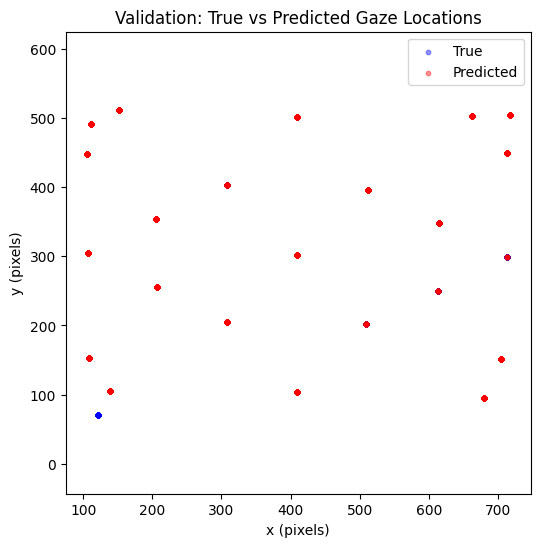

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# True locations (blue)
plt.scatter(
    true_xy[:, 0],
    true_xy[:, 1],
    c="blue",
    s=10,
    alpha=0.4,
    label="True"
)

# Predicted locations (red)
plt.scatter(
    pred_xy[:, 0],
    pred_xy[:, 1],
    c="red",
    s=10,
    alpha=0.4,
    label="Predicted"
)

plt.legend()
plt.title("Validation: True vs Predicted Gaze Locations")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.axis("equal")
plt.show()

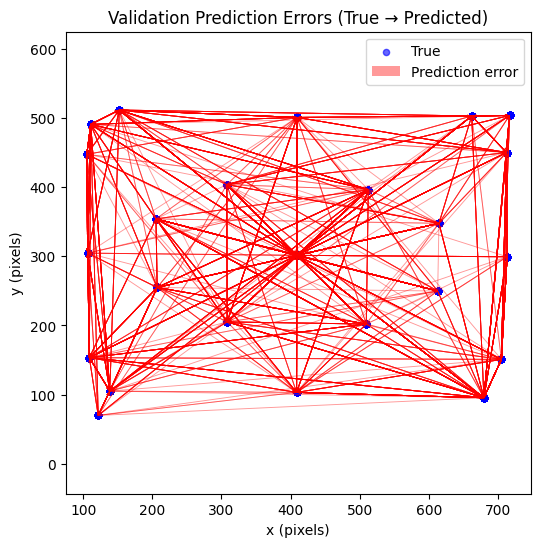

In [ ]:
plt.figure(figsize=(6,6))

# plot true positions
plt.scatter(
    true_xy[:,0],
    true_xy[:,1],
    c="blue",
    s=20,
    alpha=0.6,
    label="True"
)

# draw arrows: true → predicted
plt.quiver(
    true_xy[:,0],
    true_xy[:,1],
    pred_xy[:,0] - true_xy[:,0],
    pred_xy[:,1] - true_xy[:,1],
    angles="xy",
    scale_units="xy",
    scale=1,
    width=0.002,
    color="red",
    alpha=0.4,
    label="Prediction error"
)

plt.title("Validation Prediction Errors (True → Predicted)")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.axis("equal")
plt.legend()
plt.show()

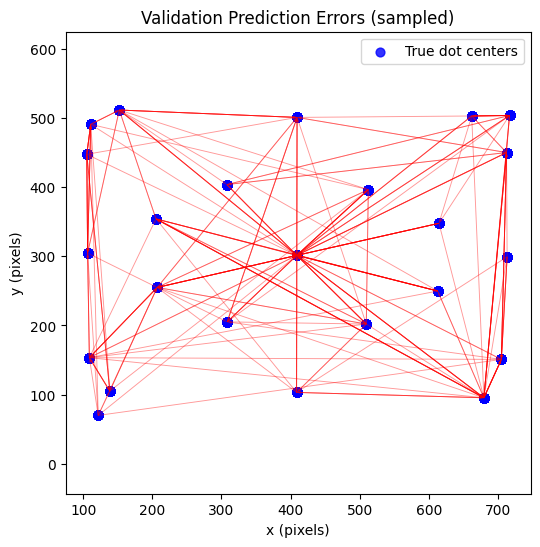

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of arrows to show
N_SHOW = 300   # 200–500 is ideal

idx = np.random.choice(len(true_xy), size=N_SHOW, replace=False)

plt.figure(figsize=(6,6))

# Plot true dot locations
plt.scatter(
    true_xy[:,0],
    true_xy[:,1],
    c="blue",
    s=40,
    alpha=0.8,
    label="True dot centers"
)

# Plot sampled error vectors
plt.quiver(
    true_xy[idx,0],
    true_xy[idx,1],
    pred_xy[idx,0] - true_xy[idx,0],
    pred_xy[idx,1] - true_xy[idx,1],
    angles="xy",
    scale_units="xy",
    scale=1,
    width=0.002,
    color="red",
    alpha=0.4
)

plt.title("Validation Prediction Errors (sampled)")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.axis("equal")
plt.legend()
plt.show()

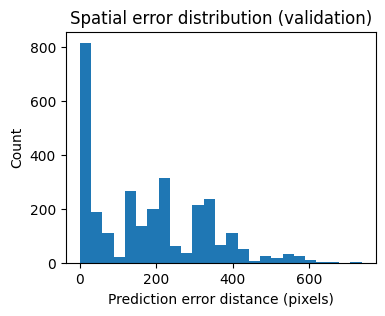

Mean error (px): 173.21313
Median error (px): 151.30327


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

error_dist = np.linalg.norm(pred_xy - true_xy, axis=1)

plt.figure(figsize=(4,3))
plt.hist(error_dist, bins=25)
plt.xlabel("Prediction error distance (pixels)")
plt.ylabel("Count")
plt.title("Spatial error distribution (validation)")
plt.show()

print("Mean error (px):", error_dist.mean())
print("Median error (px):", np.median(error_dist))

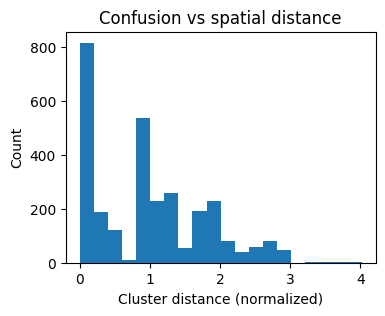

In [ ]:
true_n = cluster_centers_n_final[all_true]
pred_n = cluster_centers_n_final[all_pred]

cluster_dist = np.linalg.norm(pred_n - true_n, axis=1)

plt.figure(figsize=(4,3))
plt.hist(cluster_dist, bins=20)
plt.xlabel("Cluster distance (normalized)")
plt.ylabel("Count")
plt.title("Confusion vs spatial distance")
plt.show()

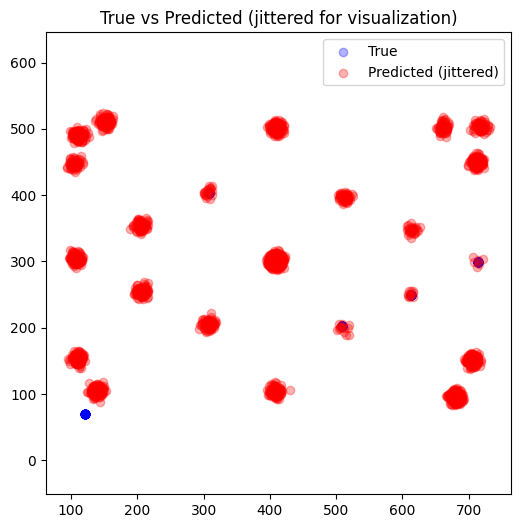

In [ ]:
noise = np.random.normal(scale=5.0, size=true_xy.shape)

plt.figure(figsize=(6,6))
plt.scatter(
    true_xy[:,0],
    true_xy[:,1],
    c="blue",
    alpha=0.3,
    label="True"
)
plt.scatter(
    pred_xy[:,0] + noise[:,0],
    pred_xy[:,1] + noise[:,1],
    c="red",
    alpha=0.3,
    label="Predicted (jittered)"
)
plt.legend()
plt.axis("equal")
plt.title("True vs Predicted (jittered for visualization)")
plt.show()

In [ ]:
K = cluster_centers_px_final.shape[0]
print("K:", K)
print("labels min/max:", all_true.min(), all_true.max(), all_pred.min(), all_pred.max())
assert all_true.min() >= 0 and all_true.max() < K
assert all_pred.min() >= 0 and all_pred.max() < K

K: 24
labels min/max: 0 23 0 23


In [ ]:
from scipy.spatial.distance import cdist
D = cdist(cluster_centers_px_final, cluster_centers_px_final)
np.fill_diagonal(D, np.inf)
nn = D.min(axis=1)
d_step = np.median(nn)  # typical 1-step dot spacing

err = np.linalg.norm(pred_xy - true_xy, axis=1)

print("Typical dot spacing (px):", d_step)
print("P(error == 0):", np.mean(err < 1e-6))
print("P(within 1 step):", np.mean(err <= 1.25 * d_step))
print("P(within 2 steps):", np.mean(err <= 2.25 * d_step))

Typical dot spacing (px): 98.02068612812356
P(error == 0): 0.27661016949152545
P(within 1 step): 0.38508474576271184
P(within 2 steps): 0.6898305084745763


In [ ]:
epochs = 20

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer
    )

    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
EEG_final = EEG_final.astype(np.float32)
chan_mean = chan_mean.astype(np.float32)
chan_std  = chan_std.astype(np.float32)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGEyeDataset(Dataset):
    def __init__(self, EEG, labels, indices, mean, std):
        self.EEG = EEG
        self.labels = labels
        self.indices = indices
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
      idx = self.indices[i]

      eeg = self.EEG[idx]
      eeg = (eeg - self.mean) / self.std
      eeg = eeg.astype(np.float32)   # ← THIS LINE MATTERS

      label = self.labels[idx]

      return (
          torch.from_numpy(eeg).float(),   # ← AND THIS
          torch.tensor(label, dtype=torch.long)
      )


In [ ]:
eeg, lbl = next(iter(train_loader))
print(eeg.dtype)   # should be torch.float32

RuntimeError: DataLoader worker (pid(s) 3728, 3729, 3730, 3731) exited unexpectedly

In [ ]:
# Convert normalized cluster centers to torch ONCE
cluster_centers_n_torch = torch.tensor(
    cluster_centers_n_final,
    dtype=torch.float32,
    device=device
)  # (K, 2)

In [ ]:
import torch.nn.functional as F

def spatial_contrastive_loss(
    z,                  # (B, D)
    labels,             # (B,)
    centers_n,          # (K, 2)
    sigma=0.32
):
    """
    Distance-weighted spatial contrastive regularizer.
    """

    # 1) Normalize embeddings → cosine similarity
    z = F.normalize(z, dim=1)          # (B, D)

    # 2) Map labels → spatial coordinates
    coords = centers_n[labels]         # (B, 2)

    # 3) Pairwise spatial distances
    spatial_dist = torch.cdist(
        coords, coords, p=2
    )                                  # (B, B)

    # 4) Spatial similarity target
    target_sim = torch.exp(
        -(spatial_dist ** 2) / (2 * sigma ** 2)
    )                                  # (B, B)

    # 5) Embedding similarity
    embed_sim = z @ z.T                # (B, B)

    # 6) Remove self-similarity
    eye = torch.eye(z.size(0), device=z.device)
    embed_sim = embed_sim * (1 - eye)
    target_sim = target_sim * (1 - eye)

    # 7) Match geometry to embeddings
    return F.mse_loss(embed_sim, target_sim)

In [ ]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for eeg, labels in loader:
        eeg = eeg.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            with torch.cuda.amp.autocast(dtype=torch.float16):

                # ---- forward pass ----
                logits, z = model(eeg)        # logits: (B, K), z: (B, D)

                # ---- classification loss ----
                ce_loss = criterion(logits, labels)

                # ---- spatial contrastive loss ----
                sp_loss = spatial_contrastive_loss(
                    z,
                    labels,
                    cluster_centers_n_torch,
                    sigma=0.32
                )

                # ---- combined loss ----
                loss = ce_loss + 0.05 * sp_loss

            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # ---- metrics ----
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [ ]:
epochs = 20

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer
    )

    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

In [ ]:
data = np.load(path)

EEG = data["EEG"]        # (N, 500, 129)
labels = data["labels"] # (N, 3)

In [ ]:
EEG = EEG[:, :, :128]           # (N, 500, 128)
xy  = labels[:, 1:3].astype(np.float32)  # (N, 2)

In [ ]:
xy_mean = xy.mean(axis=0)
xy_std  = xy.std(axis=0)
xy_std[xy_std < 1e-6] = 1.0

xy_n = (xy - xy_mean) / xy_std

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, n_init=20, random_state=42)
cluster_id = kmeans.fit_predict(xy_n)
cluster_centers_n = kmeans.cluster_centers_
cluster_centers_px = cluster_centers_n * xy_std + xy_mean

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    EEG_final,
    cluster_id_final,
    test_size=0.2,
    random_state=42,
    stratify=cluster_id_final
)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val,   dtype=torch.long)

In [ ]:
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
criterion = nn.CrossEntropyLoss()

cluster_centers_n_torch = torch.tensor(
    cluster_centers_n_final,
    dtype=torch.float32,
    device=device
)

sigma = 0.32
lambda_spatial = 0.05

In [ ]:
def spatial_contrastive_loss(z, labels, centers_n, sigma):
    z = F.normalize(z, dim=1)
    coords = centers_n[labels]
    d = torch.cdist(coords, coords)
    target = torch.exp(-(d**2) / (2 * sigma**2))
    sim = z @ z.T

    eye = torch.eye(z.size(0), device=z.device)
    sim = sim * (1 - eye)
    target = target * (1 - eye)

    return F.mse_loss(sim, target)

In [ ]:
model = EEGViTClassifier(
    num_classes=cluster_centers_n_final.shape[0],
    embed_dim=256
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scaler = torch.amp.GradScaler("cuda")

In [ ]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, correct, total = 0.0, 0, 0

    for eeg, labels in loader:
        eeg = eeg.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            with torch.cuda.amp.autocast(dtype=torch.float16):
                logits, z = model(eeg)
                ce = criterion(logits, labels)
                sp = spatial_contrastive_loss(
                    z, labels, cluster_centers_n_torch, sigma
                )
                loss = ce + lambda_spatial * sp

            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [ ]:
print("Final EEG:", EEG_final.shape)
print("Final clusters:", cluster_centers_n_final.shape[0])

Final EEG: (19670, 500, 128)
Final clusters: 24


In [ ]:
epochs = 30

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_epoch(model, val_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

/tmp/ipython-input-1931959178.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Epoch 01 | Train: loss=2.8669, acc=0.139 | Val: loss=2.4927, acc=0.215
Epoch 02 | Train: loss=2.2804, acc=0.249 | Val: loss=2.1103, acc=0.288
Epoch 03 | Train: loss=2.0644, acc=0.310 | Val: loss=1.9802, acc=0.325
Epoch 04 | Train: loss=1.9339, acc=0.347 | Val: loss=1.8779, acc=0.361
Epoch 05 | Train: loss=1.8288, acc=0.376 | Val: loss=1.9076, acc=0.345
Epoch 06 | Train: loss=1.7667, acc=0.392 | Val: loss=1.7890, acc=0.381
Epoch 07 | Train: loss=1.7112, acc=0.408 | Val: loss=1.7872, acc=0.389
Epoch 08 | Train: loss=1.6716, acc=0.421 | Val: loss=1.7695, acc=0.403
Epoch 09 | Train: loss=1.6359, acc=0.436 | Val: loss=1.6635, acc=0.430
Epoch 10 | Train: loss=1.6022, acc=0.448 | Val: loss=1.6873, acc=0.435
Epoch 11 | Train: loss=1.5767, acc=0.455 | Val: loss=1.6835, acc=0.436
Epoch 12 | Train: loss=1.5470, acc=0.465 | Val: loss=1.7051, acc=0.424
Epoch 13 | Train: loss=1.5303, acc=0.470 | Val: loss=1.6547, acc=0.437
Epoch 14 | Train: loss=1.5217, acc=0.482 | Val: loss=1.6515, acc=0.450
Epoch 

KeyboardInterrupt: 

In [ ]:
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "val_acc": val_acc,
    "val_loss": val_loss,

    # geometry (critical for inference + plots)
    "cluster_centers_n": cluster_centers_n_final,
    "cluster_centers_px": cluster_centers_px_final,
    "xy_mean": xy_mean,
    "xy_std": xy_std,

    # hyperparameters (no guessing later)
    "sigma": sigma,
    "lambda_spatial": lambda_spatial,
}

In [ ]:
SPATIAL_EPOCHS = 12      # apply spatial loss only for first N epochs
sigma = 0.32             # normalized
lambda_spatial = 0.05    # regularization weight

In [ ]:
def run_epoch(model, loader, optimizer=None, epoch=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for eeg, labels in loader:
        eeg = eeg.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            with torch.cuda.amp.autocast(dtype=torch.float16):

                logits, z = model(eeg)
                ce = criterion(logits, labels)

                # 🔑 OPTION A: anneal spatial loss
                if is_train and epoch <= SPATIAL_EPOCHS:
                    sp = spatial_contrastive_loss(
                        z,
                        labels,
                        cluster_centers_n_torch,
                        sigma
                    )
                    loss = ce + lambda_spatial * sp
                else:
                    loss = ce

            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [ ]:
epochs = 30
best_val_acc = 0.0

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer, epoch
    )
    val_loss, val_acc = run_epoch(
        model, val_loader, epoch=epoch
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

/tmp/ipython-input-2150627799.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Epoch 01 | Train: loss=3.0189, acc=0.105 | Val: loss=2.8180, acc=0.113
Epoch 02 | Train: loss=2.6095, acc=0.176 | Val: loss=2.3201, acc=0.241
Epoch 03 | Train: loss=2.2553, acc=0.259 | Val: loss=2.0829, acc=0.307
Epoch 04 | Train: loss=2.0524, acc=0.312 | Val: loss=1.9727, acc=0.335
Epoch 05 | Train: loss=1.9381, acc=0.342 | Val: loss=1.8847, acc=0.356
Epoch 06 | Train: loss=1.8626, acc=0.365 | Val: loss=1.8770, acc=0.357
Epoch 07 | Train: loss=1.8046, acc=0.386 | Val: loss=1.7830, acc=0.394
Epoch 08 | Train: loss=1.7484, acc=0.401 | Val: loss=1.7444, acc=0.397
Epoch 09 | Train: loss=1.7015, acc=0.416 | Val: loss=1.7707, acc=0.401
Epoch 10 | Train: loss=1.6689, acc=0.431 | Val: loss=1.7531, acc=0.405
Epoch 11 | Train: loss=1.6504, acc=0.431 | Val: loss=1.7803, acc=0.396
Epoch 12 | Train: loss=1.6482, acc=0.430 | Val: loss=1.7054, acc=0.409
Epoch 13 | Train: loss=1.6150, acc=0.440 | Val: loss=1.7792, acc=0.407
Epoch 14 | Train: loss=1.5930, acc=0.448 | Val: loss=1.7166, acc=0.416
Epoch 

In [ ]:
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for eeg, labels in val_loader:
        eeg = eeg.to(device)
        logits, _ = model(eeg)

        preds = logits.argmax(dim=1).cpu().numpy()
        labels = labels.numpy()

        all_pred.append(preds)
        all_true.append(labels)

all_pred = np.concatenate(all_pred)
all_true = np.concatenate(all_true)

In [ ]:
true_xy = cluster_centers_px_final[all_true]   # (N, 2)
pred_xy = cluster_centers_px_final[all_pred]   # (N, 2)

pixel_error = np.linalg.norm(pred_xy - true_xy, axis=1)

print("Mean pixel error:", pixel_error.mean())
print("Median pixel error:", np.median(pixel_error))

Mean pixel error: 123.98292
Median pixel error: 54.709156


In [ ]:
# Compute normalized cluster distances
from scipy.spatial.distance import cdist

D = cdist(cluster_centers_n_final, cluster_centers_n_final)

step_dist = D[all_true, all_pred]  # (N,)

# One-step threshold = median NN distance
nn_dist = np.sort(D + np.eye(D.shape[0]) * 1e9, axis=1)[:, 0]
one_step = np.median(nn_dist)

print("P(exact):", np.mean(step_dist == 0))
print("P(within 1 step):", np.mean(step_dist <= one_step))
print("P(within 2 steps):", np.mean(step_dist <= 2 * one_step))

P(exact): 0.45221148957803764
P(within 1 step): 0.543467208947636
P(within 2 steps): 0.7150482968988308


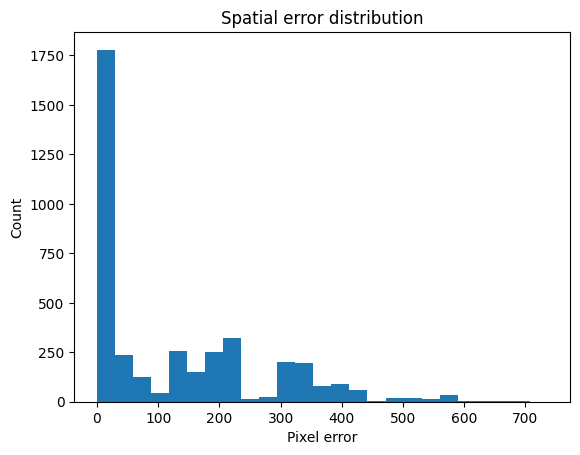

In [ ]:
import matplotlib.pyplot as plt

plt.hist(pixel_error, bins=25)
plt.xlabel("Pixel error")
plt.ylabel("Count")
plt.title("Spatial error distribution")
plt.show()